In [1]:
import pandas as pd
from openai import OpenAI
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json
import re
import numpy as np

# Load CSV file
df = pd.read_csv('./csv/ocr/dankmemes-con-ocr.csv')

config_json = json.load(open('config.json'))
openai = OpenAI(
    api_key=config_json['openai_key']
)

# Function to get OpenAI text embeddings
def get_openai_embedding(text, model="text-embedding-ada-002"):
    print(text)
    response = openai.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

def clean(t):
    text = str(t).lower()
    text = re.sub(r"\[(.*?)\]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\w+…|…", "", text)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)
    text = re.sub(r"made with me matic", " ", text)
    text = re.sub(r"me matic", " ", text)
    text = re.sub(r"img flip com", " ", text)
    text = re.sub(r"img i ipcom", " ", text)
    text = re.sub(r"flip com", " ", text)
    text = re.sub(r"img lip com", " ", text)
    text = re.sub(r"img lip", " ", text)
    text = re.sub(r"lip com", " ", text)
    text = re.sub(r"tenor", " ", text)
    text = re.sub(r"reddito rs", "redditors", text)
    tokens = text.split()
    tokens = ["" if t.isdigit() else t for t in tokens]
    tokens = [t for t in tokens if len(t) > 1]
    
    return " ".join(tokens)

df['combined_text'] = df['text'].fillna('') + ' ' + df['caption'].fillna('')
df['combined_text'] = df['combined_text'].apply(clean)


In [2]:
import os

# Check if embeddings file exists, otherwise compute and save
embeddings_file = 'dankmemes-con.csv'

if not os.path.exists(embeddings_file):
    # Apply OpenAI embedding to the 'combined_text' column
    df['embedding'] = df['combined_text'].apply(lambda x: get_openai_embedding(x))

    # Convert the list embeddings into a 2D NumPy array
    embeddings_array = np.vstack(df['embedding'])

    # Save the embeddings to a CSV file
    df.to_csv(embeddings_file, index=False)
else:
    # Load embeddings from the existing file
    df = pd.read_csv(embeddings_file)

holyshttthbtettgsolongi wonder whtshisseemticanbedihhm nod worm hhm never aga jn gfi ple mom hope you ejnoy tihs raedable mmem
administrator windows power shell administrator command prompt ps windows system lacks originality the name sounds proprietary and cheesy not staple of computer culture help function doesnt even really help ugly blue screen of death looking interface windows system type chad ini has an awesome direct name will only accept your stern no nonsense commands it doesnt do smalltalk help function actually helps you sexy monochrome inter ace ihh8s eaea edea windows system k88 spent minutes in powershell and command prompt to make this
gen when someone says ski bidi toilet so funny
andrew garfield reveals he hates mondays and loves lasagna in new interview by britta devore published hours ago during his career in hollywood andrew garfield has amassed slew of awards and nominations from prestigious groups like the golden globes bafta and even the academy but for his role

In [3]:
# Extract the embeddings into a NumPy array
embeddings_array = np.vstack(df['embedding'])

# Calculate inertia for different values of k
inertia = []
k_values = range(1, 30)
for k in k_values:  # You can adjust the range of k
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np.vstack(df['embedding']))
    inertia.append(kmeans.inertia_)

/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

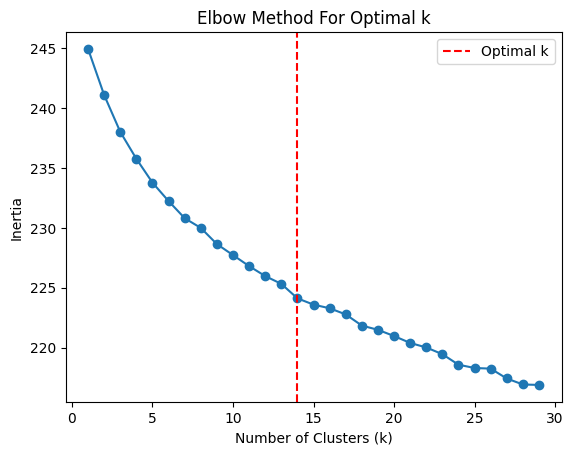

/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=14, random_state=42)

In [5]:
from kneed import KneeLocator

knee_locator = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.axvline(x=optimal_k, color='r', linestyle='--', label='Optimal k')
plt.legend()
plt.show()

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(np.vstack(df['embedding']))

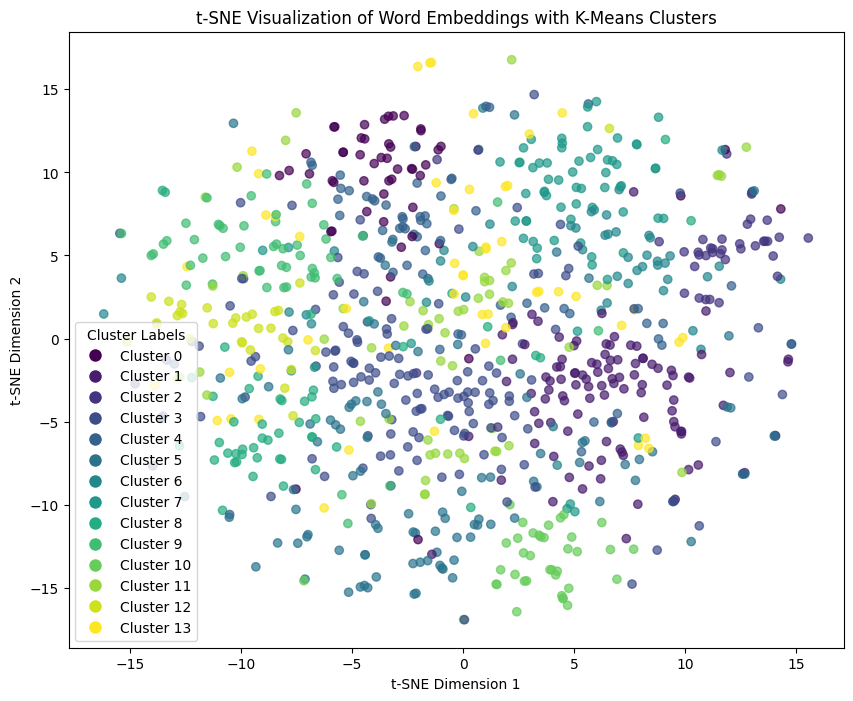

In [6]:
# Apply t-SNE to the embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=80)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Add the 2D embeddings to the DataFrame
df['tsne_x'] = embeddings_2d[:, 0]
df['tsne_y'] = embeddings_2d[:, 1]

# Visualize the clusters with t-SNE and annotate with label names
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['tsne_x'], df['tsne_y'], c=kmeans.labels_, cmap='viridis', alpha=0.7)

# Annotate with label names
# for i, txt in enumerate(df['combined_text'].sample(10)):  # You can adjust the number of samples
#    plt.annotate(txt, (df['tsne_x'].iloc[i], df['tsne_y'].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')

# Add legend with label names
legend_labels = {label: f'Cluster {label}' for label in set(kmeans.labels_)}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=legend_labels[label]) for label in set(kmeans.labels_)]
plt.legend(handles=legend_handles, title='Cluster Labels')

plt.title('t-SNE Visualization of Word Embeddings with K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

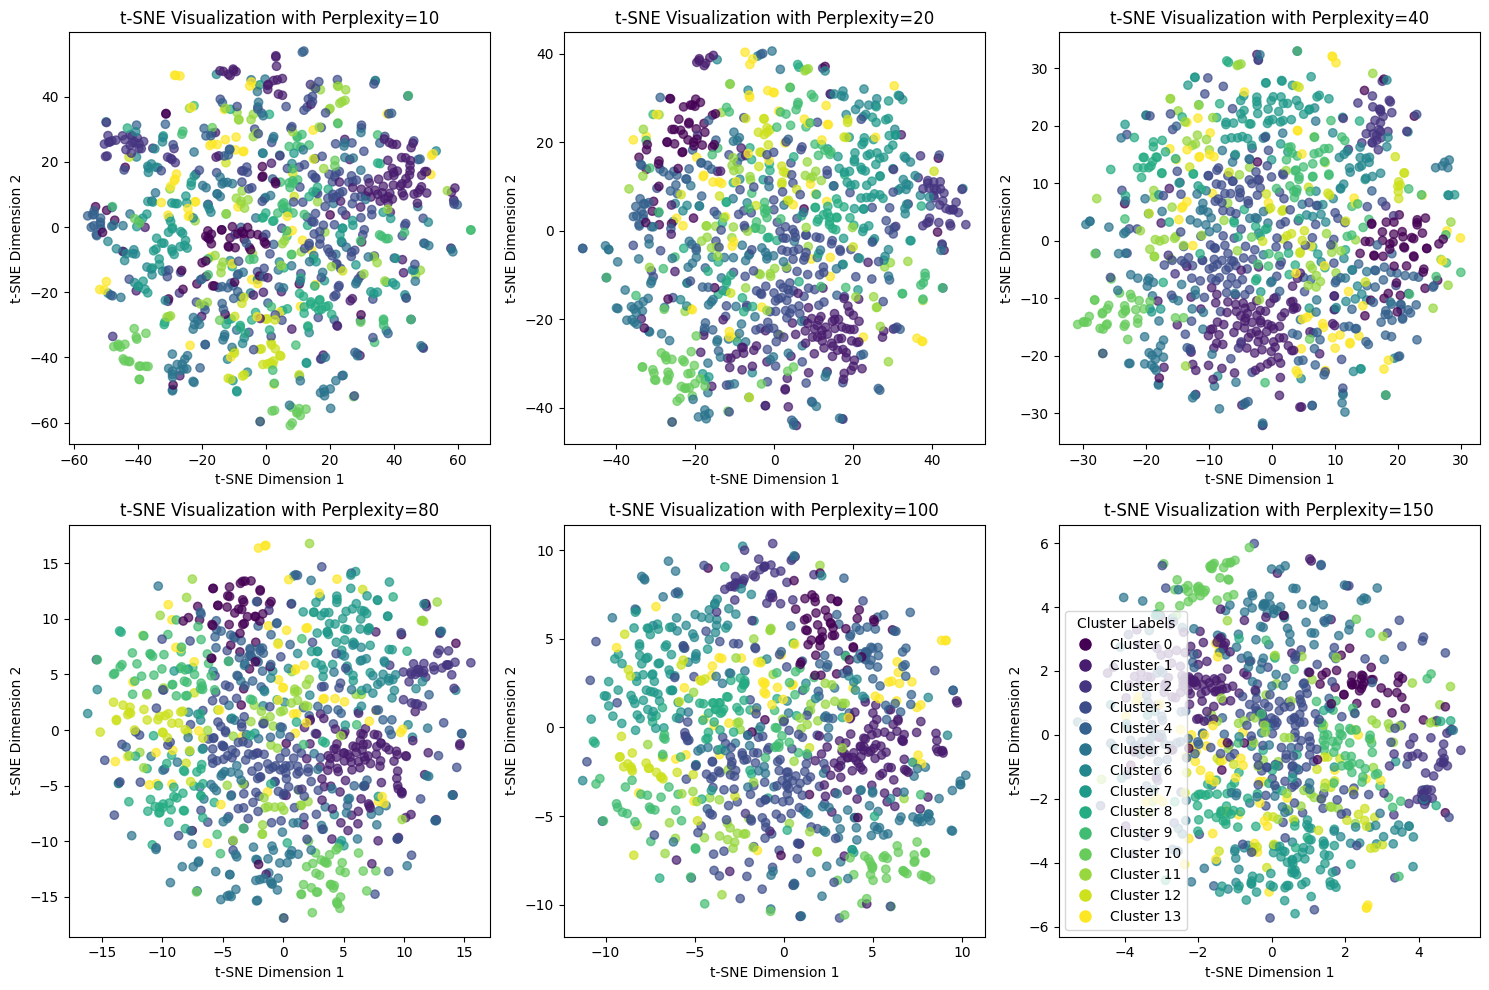

In [7]:
# Function to visualize t-SNE with different perplexity values
def visualize_tsne_with_perplexity(embeddings_array, perplexity_values):
    num_perplexities = len(perplexity_values)

    # Adjust the number of rows and columns for subplots
    num_rows = 2
    num_cols = int(np.ceil(num_perplexities / num_rows))

    plt.figure(figsize=(15, 10))

    for i, perplexity in enumerate(perplexity_values, start=1):
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings_array)

        plt.subplot(num_rows, num_cols, i)
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
        plt.title(f't-SNE Visualization with Perplexity={perplexity}')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')

        # Annotate with label names (optional)
        # for j, txt in enumerate(df['combined_text'].sample(10)):  # You can adjust the number of samples
        #     plt.annotate(txt, (embeddings_2d[j, 0], embeddings_2d[j, 1]), textcoords="offset points", xytext=(0,5), ha='center')

    # Add legend with label names
    legend_labels = {label: f'Cluster {label}' for label in set(kmeans.labels_)}
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=legend_labels[label]) for label in set(kmeans.labels_)]
    plt.legend(handles=legend_handles, title='Cluster Labels')

    plt.tight_layout()
    plt.show()

# Perplexity values to visualize
perplexity_values = [10, 20, 40, 80, 100, 150]

# Visualize t-SNE with different perplexity values
visualize_tsne_with_perplexity(embeddings_array, perplexity_values)


In [12]:

# Get centroids of each cluster
centroids = kmeans.cluster_centers_

# Function to find representative samples from each cluster
def print_cluster_representatives(cluster_id, num_representatives=5):
    print(f"Cluster {cluster_id + 1} representatives:")
    # Find indices of data points in the cluster
    cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]

    # Calculate distances from centroid for each data point in the cluster
    distances = np.linalg.norm(embeddings_array[cluster_indices] - centroids[cluster_id], axis=1)

    # Get indices of num_representatives samples with smallest distances
    representative_indices = cluster_indices[np.argsort(distances)[:num_representatives]]

    # Print representative samples
    for i, index in enumerate(representative_indices, start=1):
        print(" ".join(f"{df.iloc[index]['caption']}: {df.iloc[index]['text']}".split("\n")))
    
    print("-" * 10)

# Print representatives from each cluster
for cluster_id in range(optimal_k):
    print_cluster_representatives(cluster_id)


Cluster 1 representatives:
Oh, Europe - you've got to realize how stupid American politics is: euro poansmakememeabout911 calendar coordi natl on americans 10 dont mess with americal suck it all losers l
Happy Veterans Day: home of the free becquseibratve of the all gave some some gave ally elev emi ez
Pride comes before the fall: when most of those around you cant get on the same level of patriotism your e on they spit on me in my made with me matic homeland make a gif com
You will get it one day...: this is a meme from the future you dont get it yet americans when point out that theyre the only nation that has been nuked four times
America be like....: we didnt see the signs thoughts and prayers
----------
Cluster 2 representatives:
skellton meme: skeezoq1171anubtkenh1boj omexiwvwwkenhubcomkgb
[Title]: meme
The true Reddit man: my fellow epic chung us p doot reddito rs my wnw s nod every look other thig us could crush make coffe you for v stem ing abou i attract a peal chud s cm ll u

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the 'combined_text' column to a list
documents = df['combined_text'].tolist()

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Function to get keywords from each cluster
def get_cluster_keywords(cluster_label, top_n=10):
    cluster_indices = np.where(kmeans.labels_ == cluster_label)[0]
    cluster_tfidf = np.sum(tfidf_matrix[cluster_indices], axis=0)
    sorted_feature_indices = np.argsort(cluster_tfidf)[0, ::-1]
    top_keywords = feature_names[sorted_feature_indices][:top_n]
    return top_keywords.tolist()

# Get keywords for each cluster
for i in range(optimal_k):  # Change to the optimal number of clusters
    keywords = get_cluster_keywords(i)
    print(f"Cluster {i + 1} Keywords: {keywords}")

Cluster 1 Keywords: [['day', 'war', 'free', 'america', 'american', 'americans', 'veterans', 'dont', 'europe', 'government', 'slaves', 'sorry', 'oh', 'like', 'healthcare', 'drugs', 'rest', 'mass', 'happy', 'got', 'thanksgiving', 'jesus', 'shooting', 'living', 'nation', 'celebrating', 'years', 'traitors', 'country', 'europeans', 'say', 'com', 'work', 'home', 'gave', 'people', 'labor', 'money', 'heard', 'eat', 'hoosier', 'attorneys', 'god', 'commies', 'blues', 'winter', 'corrupt', 'gonna', 'union', 'thanks', 'hit', 'complain', 'veteran', 'ptsd', 'general', 'canada', 'spirit', 'surprise', 'conflict', 'proxy', 'world', 'point', 'land', 'feel', 'stupid', 'signs', 'prayers', 'failed', 'anymore', 'freedom', 'wastes', 'govern', 'panik', 'city', 'yes', 'bless', 'state', 'mom', 'tentlife', 'dead', 'gaza', 'worry', 'fan', 'aliens', 'soviet', 'served', 'look', 'thoughts', 'england', 'und', 'moment', 'capitalism', 'lit', 'prohibition', 'friend', 'usa', 'happens', 'wars', 'differently', 'slightly', '